# Process with exponential/linear feed

In this process the feed is proportional to biomass. This means, for a single cell the condition do not change within a phase. To avoid the effect of metabolimic changes we saw for the exponential feed, we include a maximum growth phase at the beginning of the process.

In [1]:
import scripts.model_exp as model_exp
import scripts.model_lin as model_lin
import scripts.plot_results as plot_results
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import os
import pickle

plt.rc('font', size=14)

In [2]:
max_cX = 40

with open("data/parameters.p", "rb") as file:
    parameter = pickle.load(file)

for dir in ["plots/exp_feed"]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [3]:
Gf = 330
t_end = 35
max_starv = 5
max_starv2 = 8
min_feed = 4
X0 = 1.52
X_end = 40
mu_max = 0.5



In [4]:
mu = np.log(40 / 1.52) / t_end
model_cons_mu=model_exp.Model(phase_profile=[('growth', mu, t_end)], **parameter)
model_cons_mu.calc()
model_cons_mu.Gf
# in this model the theoratical max biomass would be higher as the avarage biomass is lower (lower mainenance)

231.23461244999567

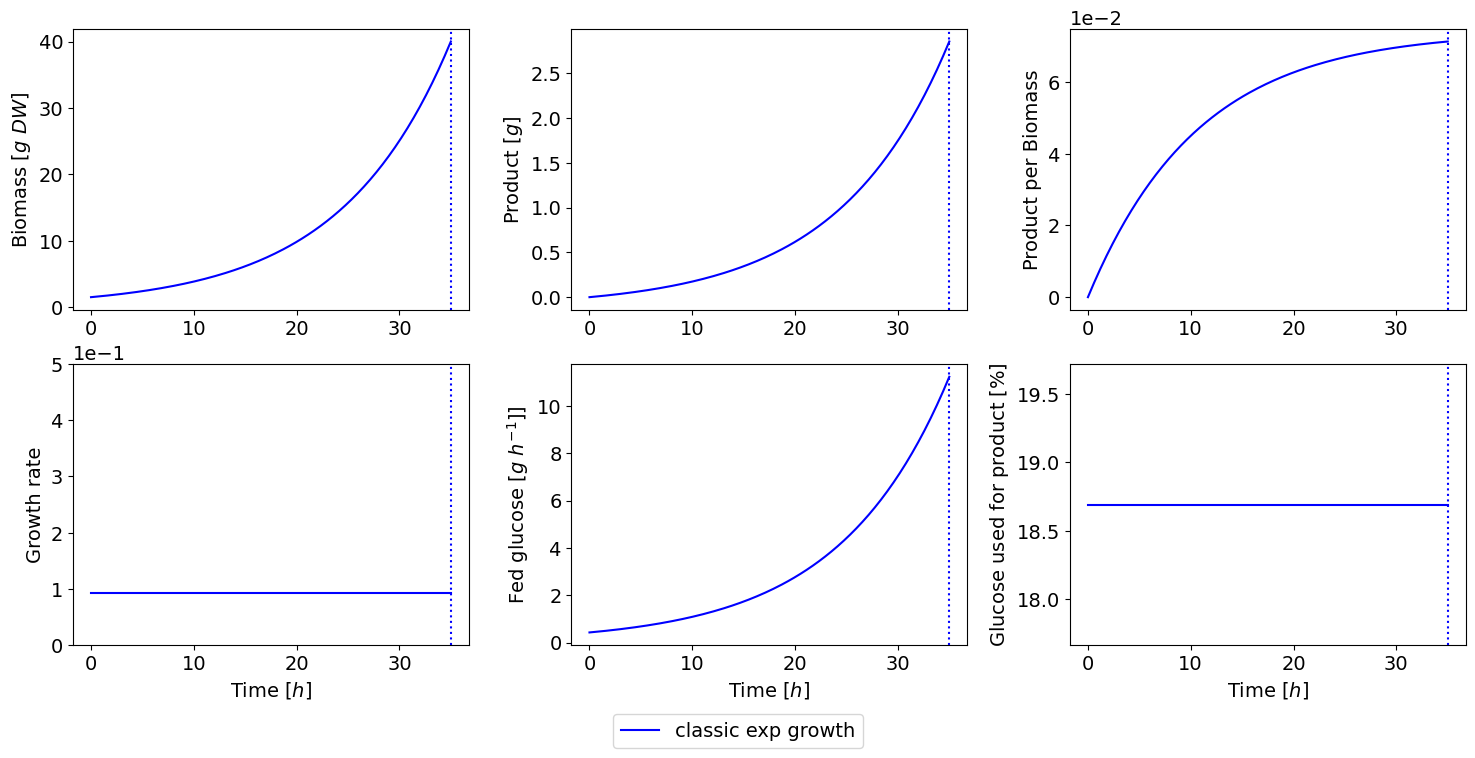

In [5]:
plot_results.plot_results(model_cons_mu, 'classic exp growth')

the model hold at least until t = 20 h
this represents about 2.7 generations of a total of about 5 (4.7 until X=40)
the target is to start with the maximum growth rate for at least 2.5 generations (biomass after this phase 8.6), 
this means the max growth phase is at least 3.5 h at mu = 0.5

In [6]:
1.52 * 2**2.5
np.log(8.6/1.52) / 0.5

3.466103736802554

In [7]:
# assume the model works for n <= 2.5, X_end = 40, mu_max = 0.5
X1 = 40 / 2**2.5
X1

7.071067811865475

In [8]:
t_max_growth = 1 / 0.5 * np.log(X1 / 1.52)
t_max_growth

3.0746023357117758

In [9]:
mu = (t_end - t_max_growth)**(-1) * np.log(2**2.5)
mu

0.05427866457990125

In [10]:
def mod_no_starv(x):
    t_max = x[0]
    X_end = max_cX
    mu = (np.log(X_end / X0) - mu_max * t_max) / (t_end - t_max)
    phase_profile = [('growth', 0.5, t_max),
                 ('growth', mu, t_end)]
    model = model_exp.Model(phase_profile=phase_profile, **parameter)
    model.calc()
    return model

def f(x):
    model = mod_no_starv(x)
    return -model.calc_X_P_end()[1]

opt = scipy.optimize.minimize(f, x0= 4, bounds=[(3, 6)])
opt

      fun: -3.075027577800188
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.5527137e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([3.08996472])

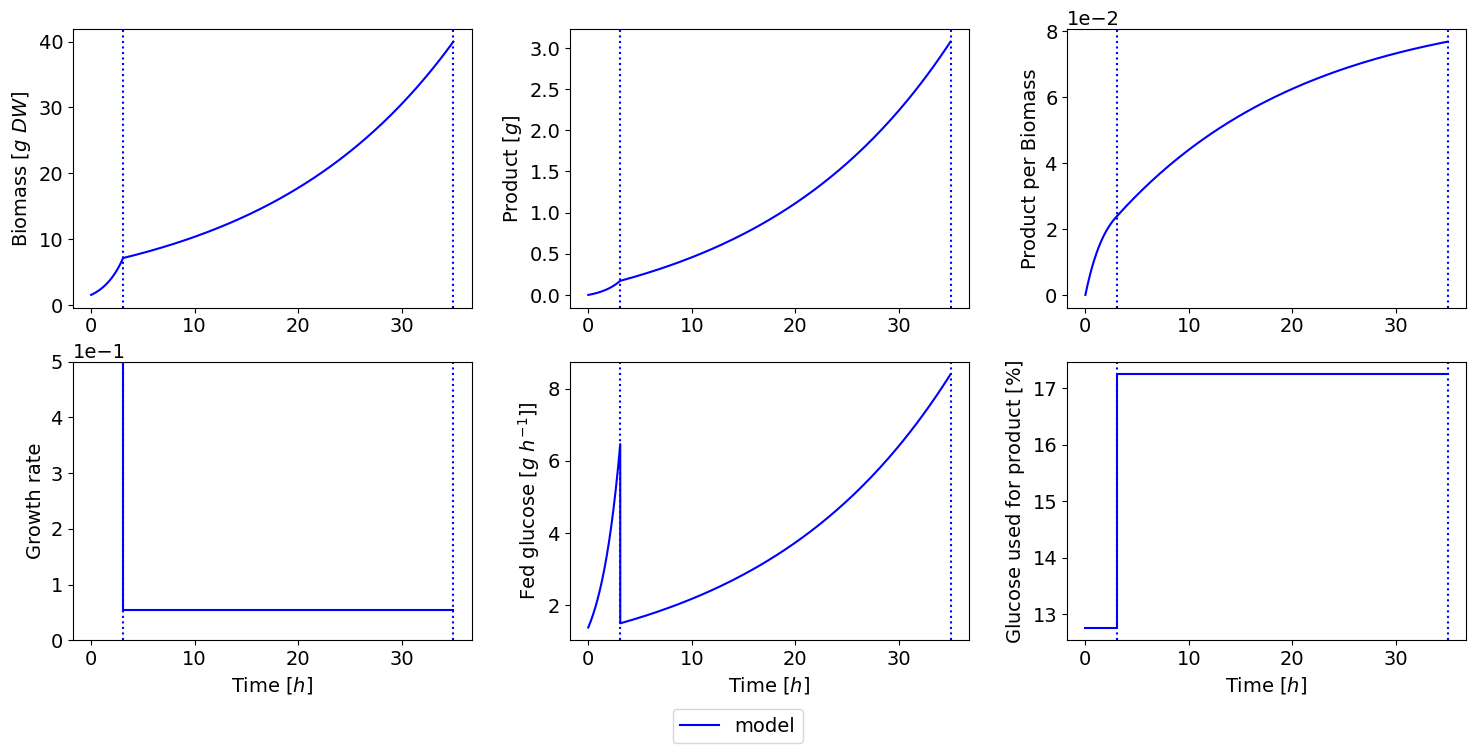

In [11]:
model_without_starvation = mod_no_starv(opt.x)
plot_results.plot_results(model_without_starvation, 'model')

In [12]:
def mod_1_starv(x):
    t_max = x[0]
    t_starv = x[1]
    mu = x[2]
    t_last_starv = t_end - t_starv
    
    phase_profile = [('growth', 0.5, t_max),
                 ('growth', mu, t_end - t_starv),
                 ('starvation', mu, t_end)]
    model = model_exp.Model(phase_profile=phase_profile, **parameter)
    model.calc()
    return model

def f(x):
    model = mod_1_starv(x)
    return -model.calc_X_P_end()[1]

def cons_1_starv(x):
    mod = mod_1_starv(x)
    mod._calc_switches()
    switch_results = pd.DataFrame(mod.switches, columns=("t", "X", "P", "V"))
    return max_cX - (switch_results.X / switch_results.V).max()

cons = {"type": "ineq", "fun": cons_1_starv}

opt = scipy.optimize.minimize(f, x0= (4, 5, 0.05), bounds=[(3, 6), (0, 8), (0, 0.2)], constraints=cons)
opt

     fun: -3.732504975004904
     jac: array([-1.61973268e+00,  9.24152732e-02, -1.04415414e+02])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 9
    njev: 8
  status: 0
 success: True
       x: array([3.        , 8.        , 0.06514304])

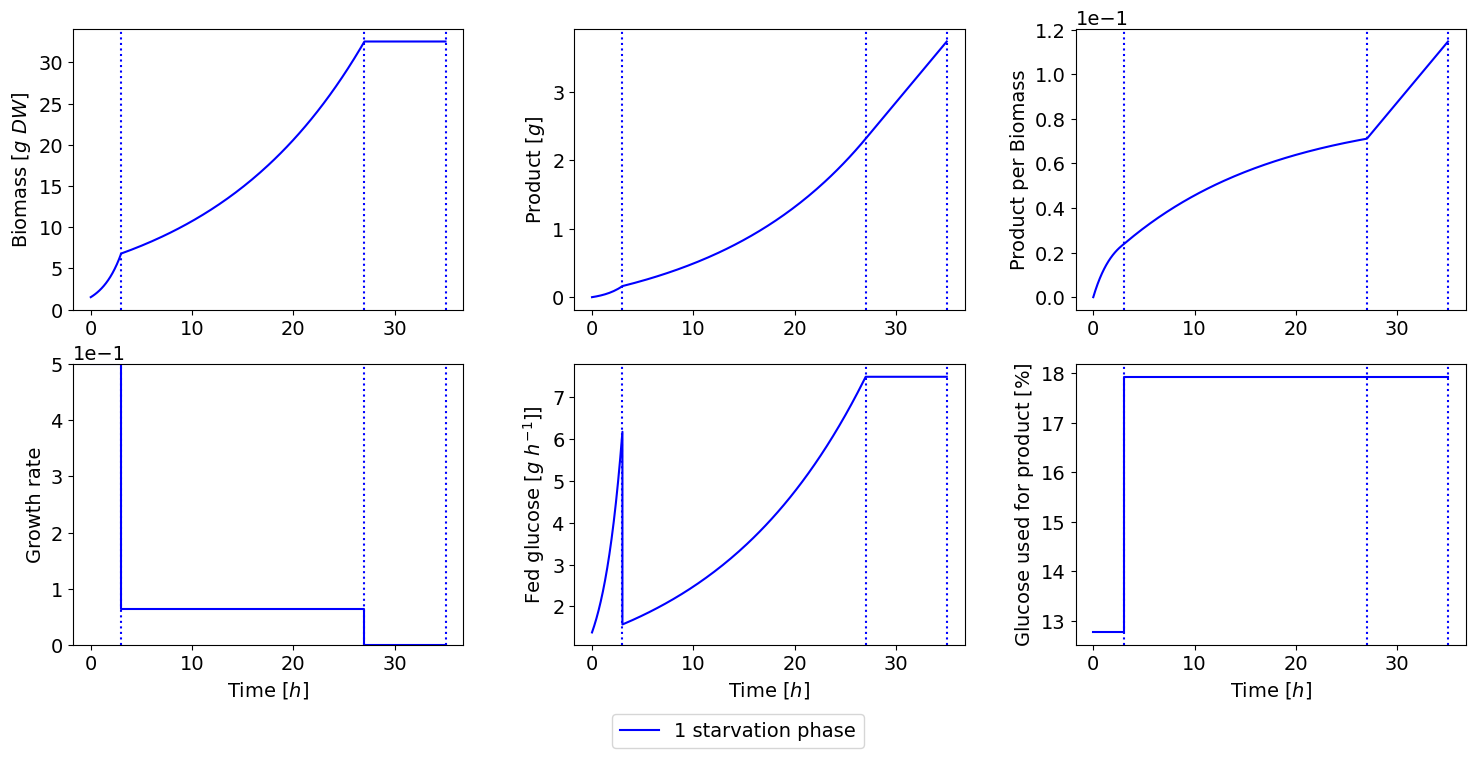

In [13]:
model_1_starv = mod_1_starv(opt.x)
plot_results.plot_results(model_1_starv, '1 starvation phase')

In [14]:
model_1_starv.Gf

321.0265080495391

In [15]:
def mod_2_starv(x):
    t_max = x[0]
    t_growth2 = x[1]
    t_starv1 = x[2]
    t_starv2 = x[3]
    mu = x[4]
    t_growth1 = t_end - t_max - t_growth2 - t_starv1 - t_starv2
    phase_profile = [
        ("growth", 0.5, t_max),
        ("growth", mu, t_max + t_growth1),
        ("starvation", mu, t_max + t_growth1 + t_starv1),
        ("growth", mu, t_end - t_starv2),
        ("starvation", mu, t_end),
    ]
    model = model_exp.Model(phase_profile=phase_profile, **parameter)
    model.calc()
    return model


def f(x):
    model = mod_2_starv(x)
    return -model.calc_X_P_end()[1]


def cons_2_starv(x):
    mod = mod_2_starv(x)
    mod._calc_switches()
    switch_results = pd.DataFrame(mod.switches, columns=("t", "X", "P", "V"))
    return max_cX - (switch_results.X / switch_results.V).max()


cons = {"type": "ineq", "fun": cons_2_starv}

opt = scipy.optimize.minimize(
    f,
    x0=(4, 5, 4, 4, 0.05),
    bounds=[(3, 6), (4, 10), (0, 5), (0, 8), (0.01, 0.2)],
    constraints=cons
)
# opt = scipy.optimize.basinhopping(
#     func=f,
#     x0=(4, 8, 4, 4, 0.05, 0.05),
#     minimizer_kwargs={
#         "bounds": [(3, 5), (4, 7), (0, 5), (0, 8), (0.01, 0.5), (0.01, 0.5)],
#         "constraints": cons,
#     },
# )

opt


     fun: -4.6112821530368135
     jac: array([-1.91701752e+00,  6.24685287e-02,  2.60876417e-01,  2.01636851e-01,
       -1.02298399e+02])
 message: 'Positive directional derivative for linesearch'
    nfev: 60
     nit: 14
    njev: 10
  status: 8
 success: False
       x: array([3.        , 4.        , 5.        , 7.99999998, 0.08275412])

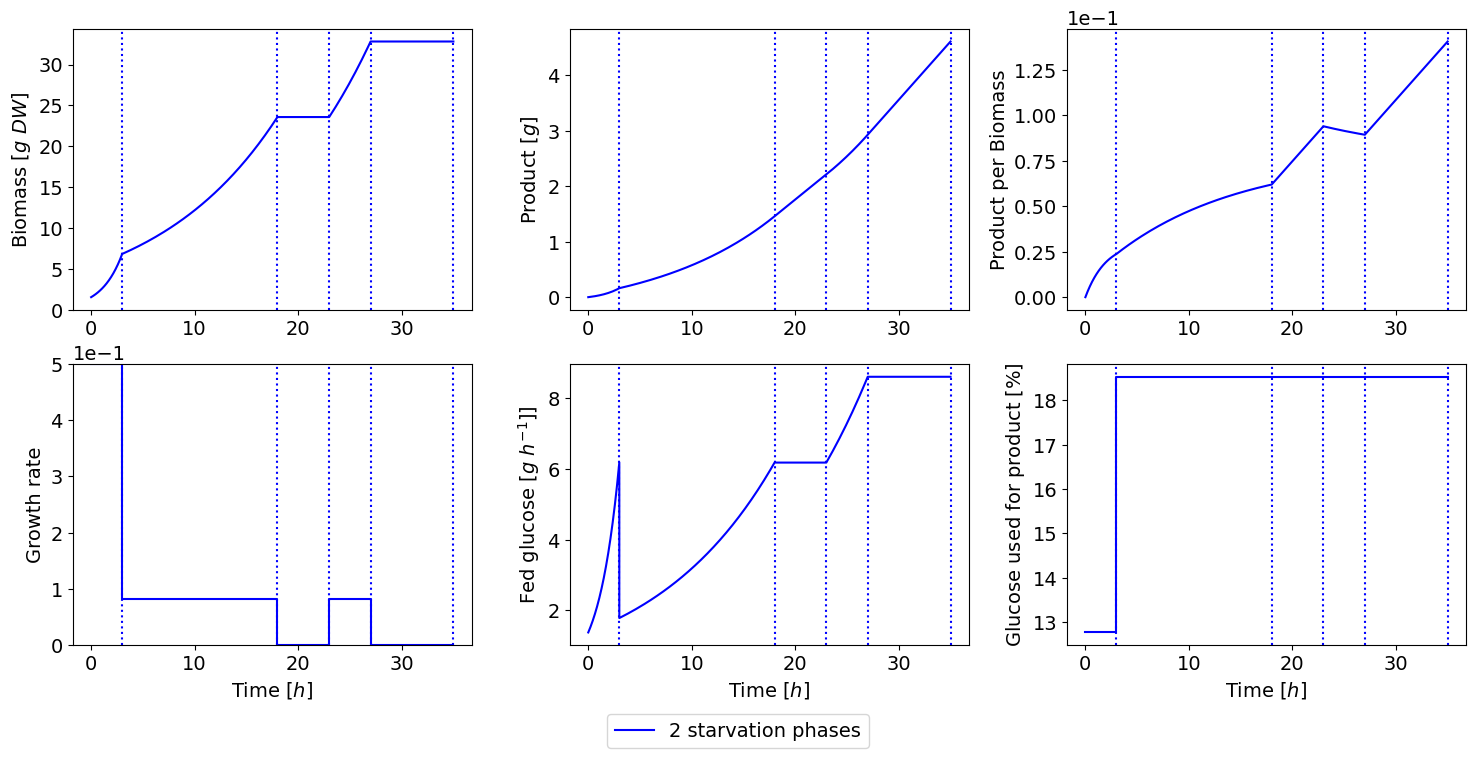

In [16]:
model_2_starv = mod_2_starv(opt.x)
plot_results.plot_results(model_2_starv, '2 starvation phases')

In [17]:
model_lin_control = model_lin.Model(**parameter)
model_lin_control.calc()

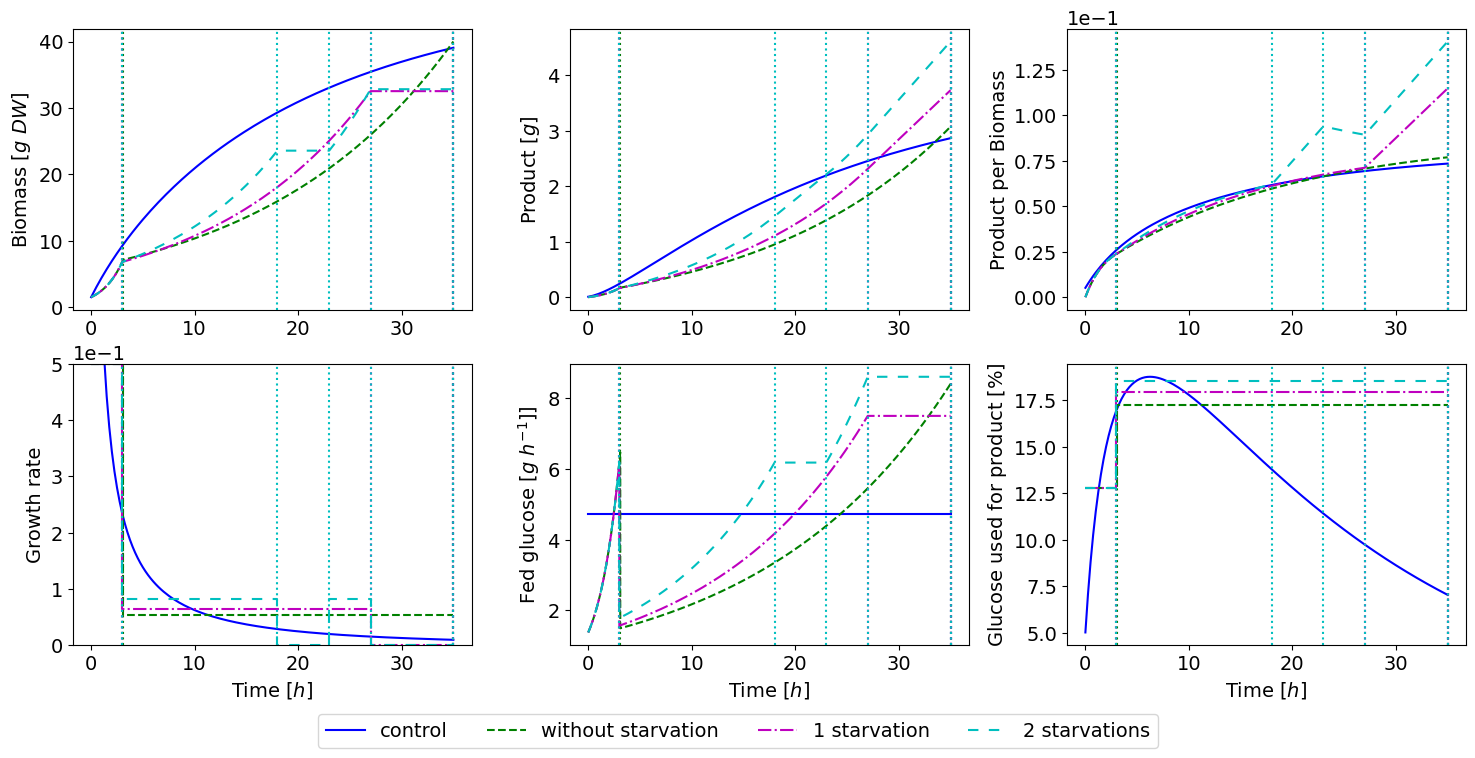

In [18]:
plot_results.plot_results(
    model_lin_control,
    model_without_starvation,
    model_1_starv,
    model_2_starv,
    "control",
    "without starvation",
    "1 starvation",
    "2 starvations",
    filename="plots/exp_feed/compare_exp.png",
)


In [19]:
# calculate improvements

def calc_parameters(model):
    model.calc()
    t = model.results.index[-1] + 9
    X = model.results.X.iloc[-1]
    P = model.results.P.iloc[-1]
    G = sum(model.results.qG * model.results.X) / len(model.results.qG) * model.phase_switches()[-1] 
    t0 = 0
    titer = P
    rate = P / t
    P_per_X = P / X
    glucose_yield = P / G
    return np.array((titer, rate, glucose_yield, P_per_X))

results_control = calc_parameters(model_lin_control)
results_0_starv = calc_parameters(model_without_starvation)
results_1_starv = calc_parameters(model_1_starv)
results_2_starv = calc_parameters(model_2_starv)

In [20]:
(results_0_starv/results_control - 1) * 100

array([ 7.23701304,  7.23701304, 28.07324491,  4.72576237])

In [21]:
(results_1_starv/results_control - 1) * 100

array([30.16555935, 30.16555935, 33.57594759, 56.31092472])

In [22]:
(results_2_starv/results_control - 1) * 100

array([60.81160636, 60.81160636, 41.28574832, 91.40240637])

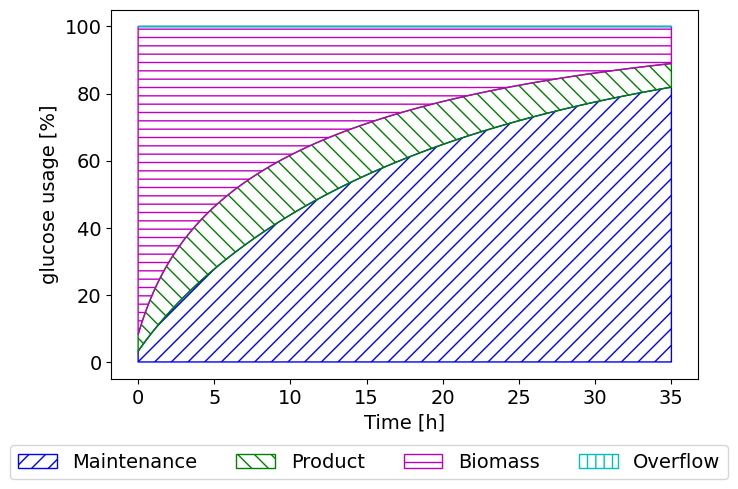

In [23]:
plot_results.energy_usage(model_lin_control, percent_only=True)

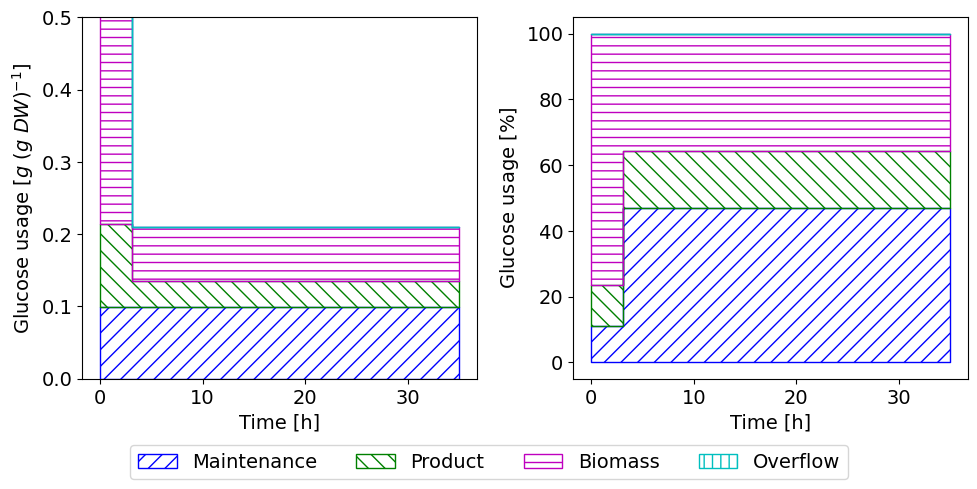

In [24]:
plot_results.energy_usage(model_without_starvation)

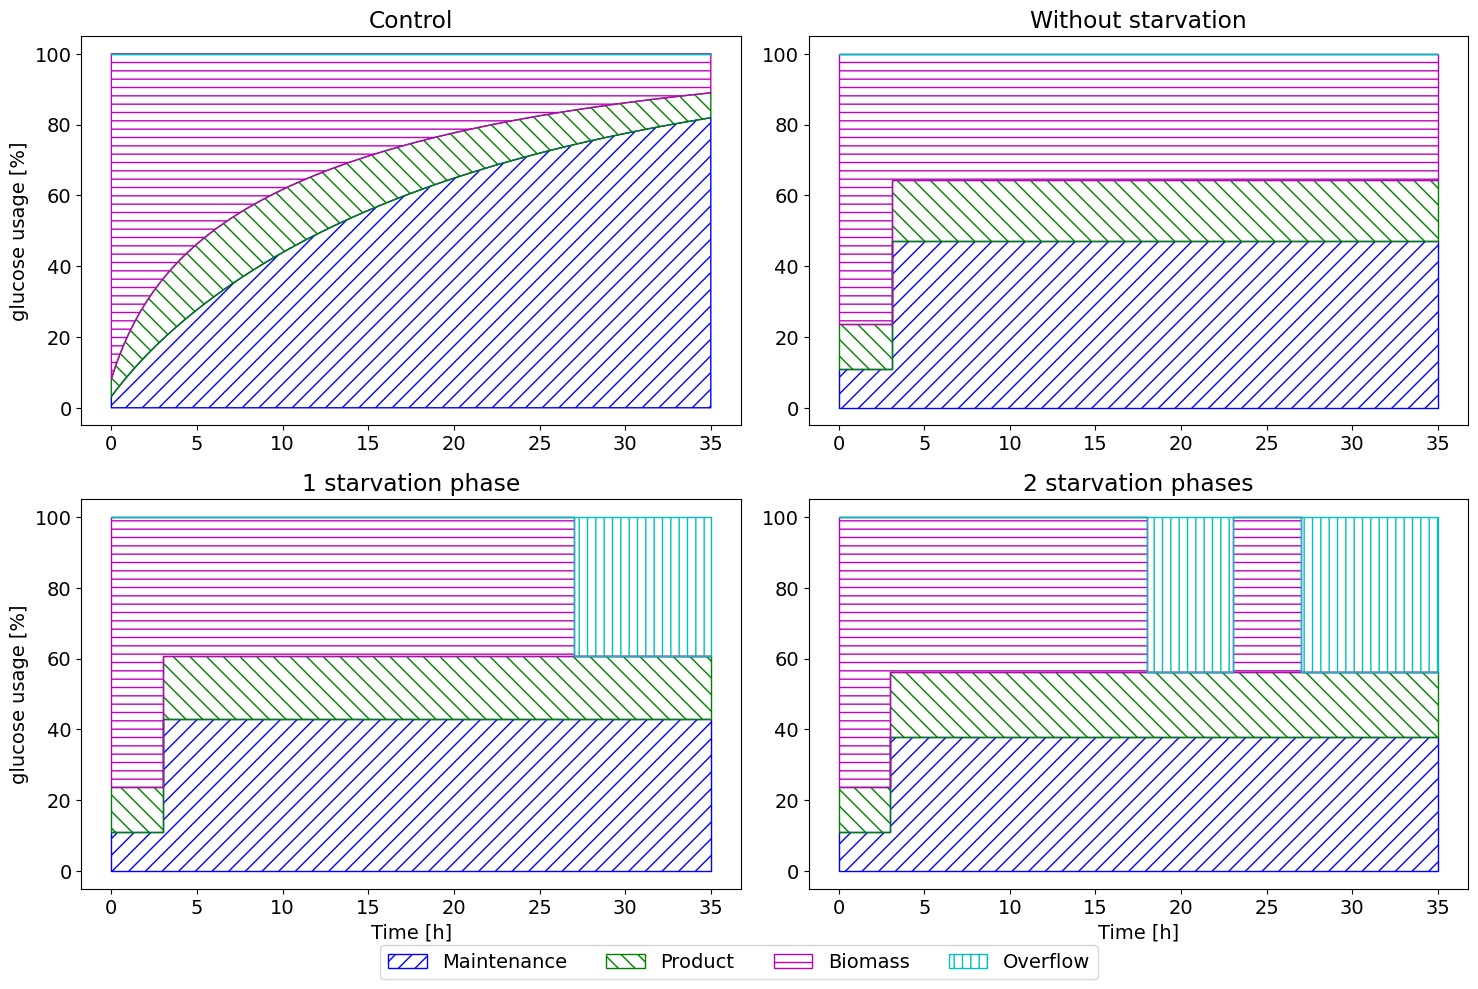

In [25]:
plot_results.energy_usage(
    model_lin_control,
    model_without_starvation,
    model_1_starv,
    model_2_starv,
    percent_only=True,
    model_titels=['Control', 'Without starvation', '1 starvation phase', '2 starvation phases'],
    filename="plots/exp_feed/energy.png"
)


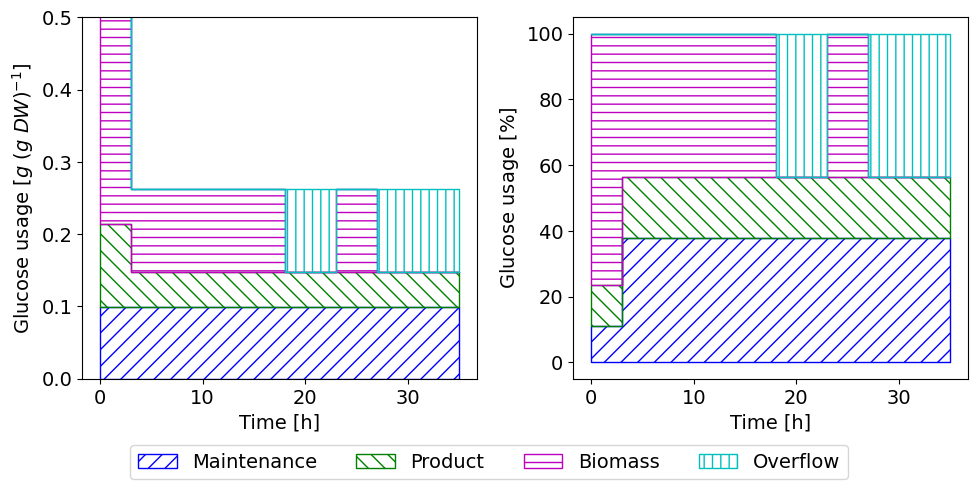

In [26]:
plot_results.energy_usage(model_2_starv)